In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter

(0.0, 0.4)

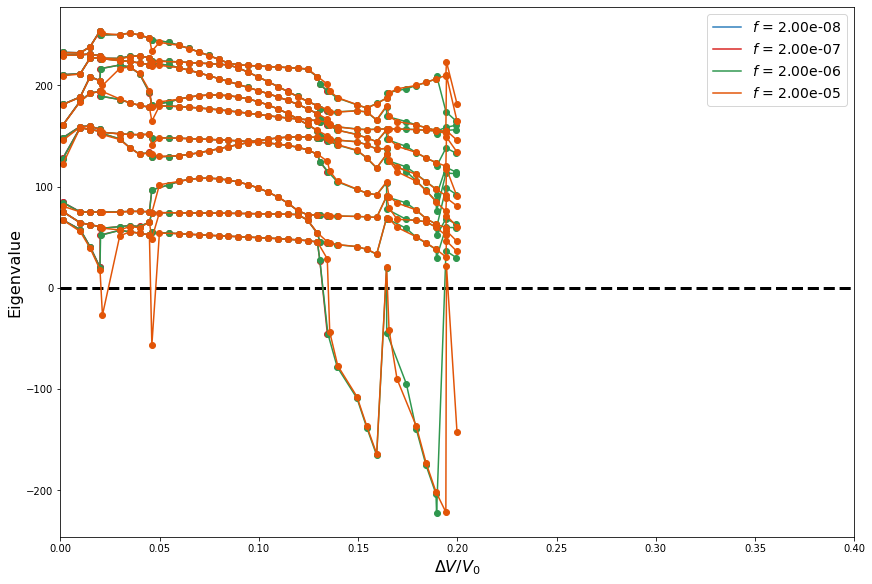

In [3]:
damping_sweep = 2*np.logspace(-8, -4, 5)

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)

initial_idx = 210

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']

ax.hlines(0,0,0.55, 'k', '--', linewidth = 3)

for i,stab_fac in enumerate(damping_sweep):
    if i < 4:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-static-stable-v{idx_cur}_eig_val.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        color_plot = plt.get_cmap(cmap_all[i])(0.7)

        for j in range(np.shape(freq_all)[1]):
            freq_rescale = np.sign(freq_all[:,j]) * np.sqrt(np.abs(freq_all[:,j])) * 1/(2*np.pi)
            # freq_rescale = freq_all[:,j]
            ax.plot(-3*temp_all, freq_rescale, 'o', color = color_plot)
            if j == 0:
                ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot, label = rf'$f$ = {stab_fac:.2e}')
            else:
                ax.plot(-3*temp_all, freq_rescale, '-', color = color_plot)



ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('Eigenvalue', fontsize = 16)
ax.set_xlim(0,0.4)
# ax.set_xlim(0.17,0.25)
# ax.set_ylim(0,60e3)
# ax.set_ylim(0,80)

#bender-static-stable-v200_multi_buckling
#data_out/bender-static-stable-v200_eig_val.txt

5652.14892578125


(-5.0, 0.0)

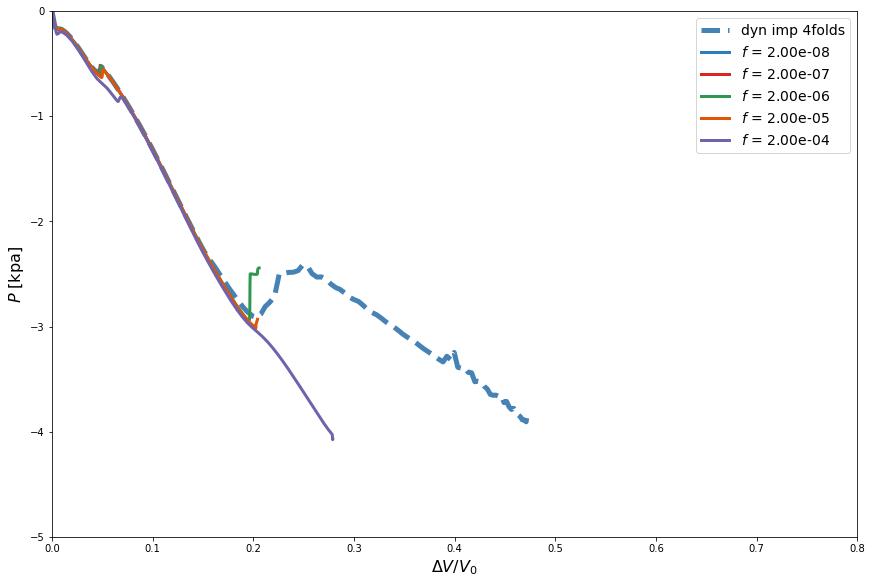

In [20]:
damping_sweep = 2*np.logspace(-8, -4, 5)

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)

initial_idx = 210

idx_cur = 140
data_cur = np.loadtxt(f'data_out/bender-dyn-imp-v{idx_cur}_pcav_cvol.txt')
# data_cur = np.loadtxt(f'data_out/4fold-fitting-{idx_cur}_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
print(data_cur[0,0])

ax.plot(vol_norm,pressure_kpa, '--', label = 'dyn imp 4folds', color = 'steelblue', linewidth = 5)
# ax.vlines(vol_norm[65], -5, 1, 'k', '--', linewidth = 3)
cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd', 'YlGn']


for i,stab_fac in enumerate(damping_sweep):
    try:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-static-stable-v{idx_cur}_pcav_cvol.txt'
        data_cur = np.loadtxt(data_path)
        
        vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
        pressure_kpa = data_cur[:,1] * 1e3

        color_plot = plt.get_cmap(cmap_all[i])(0.7)
        ax.plot(vol_norm,pressure_kpa, label = rf'$f$ = {stab_fac:.2e}', color = color_plot, linewidth = 3)
    except: pass



ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('$P$ [kpa]', fontsize = 16)
ax.set_xlim(0,0.8)
ax.set_ylim(-5,0)

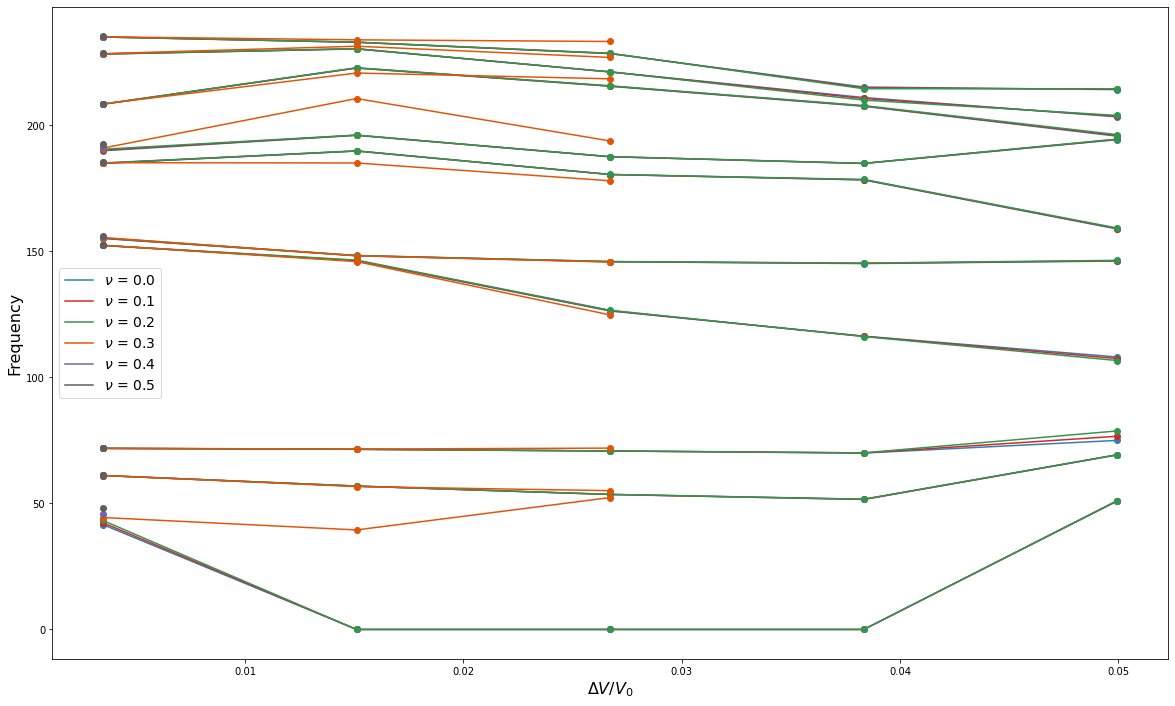

In [9]:
'''old nonsense'''
nu_try = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (20,12))

initial_idx = 410

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd']

for i,nu in enumerate(nu_try):
    if nu >= 0.0:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-test_nu-{idx_cur}_eig_freq.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        color_plot = plt.get_cmap(cmap_all[i])(0.7)

        for j in range(np.shape(freq_all)[1]):
            ax.plot(-3*temp_all, freq_all[:,j], 'o', color = color_plot)
            if j == 0:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, label = rf'$\nu$ = {nu}')
            else:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot)



ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)


fig.savefig('data_processed/change_nu_bender_freq.jpg')
